In [ ]:
import pandas as pd
import numpy as np

In [2]:
# importing the data

results  = pd.read_csv("https://github.com/felipereis150/world_cup/blob/main/data/results.csv?raw=true", parse_dates=['date'])
goalscoers  = pd.read_csv("https://github.com/felipereis150/world_cup/blob/main/data/goalscorers.csv?raw=true", parse_dates=['date'])
shootouts  = pd.read_csv("https://github.com/felipereis150/world_cup/blob/main/data/shootouts.csv?raw=true", parse_dates=['date'])
conf_names = pd.read_csv('https://github.com/felipereis150/world_cup/blob/main/data/confederation_names.csv?raw=true',encoding='ISO-8859-1', sep = ';', engine='python')
cities = pd.read_csv('https://github.com/felipereis150/world_cup/blob/EDA/data/worldcities.csv?raw=true')

In [3]:
# creating a new dataframe with all the data

futebol_df = results.merge(shootouts, on=['home_team', 'away_team'], how='left')
futebol_df = futebol_df.merge(goalscoers, on=['home_team', 'away_team'], how='left')
futebol_df = futebol_df.merge(conf_names, left_on='country', right_on='country', how='left')

In [4]:
# cleaning and transforming the data

world_cup = futebol_df[futebol_df['tournament'] == 'FIFA World Cup']
world_cup['year'] = world_cup['date'].dt.year
world_cup['decade'] = world_cup['year'].apply(lambda x: str(x)[2:3] + '0s')
world_cup = world_cup[world_cup['year'] > 1930]
world_cup.reset_index(inplace=True)
world_cup['year'] = world_cup['year'].astype(int)
cities.drop_duplicates(subset=['city_ascii'], inplace=True)

# merging the data

world_cup = world_cup.merge(cities[['city', 'lat', 'lng']], left_on='city', right_on='city', how='left')
world_cup = world_cup.drop(columns=['index', 'date_x', 'neutral', 'date_y', 'own_goal', 'minute', 'penalty'])
world_cup.rename(columns={'acronysm': 'conf', 'lng': 'lon'}, inplace=True)

C:\Users\felip\AppData\Local\Temp\ipykernel_9836\3209749711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_cup['year'] = world_cup['date'].dt.year
C:\Users\felip\AppData\Local\Temp\ipykernel_9836\3209749711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_cup['decade'] = world_cup['year'].apply(lambda x: str(x)[2:3] + '0s')


In [5]:
# checking for null values
world_cup.isna().sum()

home_team                0
away_team                0
home_score               0
away_score               0
tournament               0
city                     0
country                  0
winner                6588
date                     0
team                     0
scorer                   0
conf                   379
confederation name     379
year                     0
decade                   0
lat                    379
lon                    379
dtype: int64

In [6]:
# creating a new column with the winner of the match
world_cup['winner'] = np.where(world_cup['home_score'] > world_cup['away_score'], world_cup['home_team'], world_cup['away_team'])

In [16]:
# cities there was most world cup matches with lat and lon
city_matches = world_cup[['home_team', 'away_team', 'city', 'lat', 'lon']].groupby(['home_team', 'away_team', 'city']).count().reset_index()
city_counts = city_matches['city'].value_counts()
top_cities = city_counts.head(100)
df_top_cities = world_cup[['city', 'lat', 'lon']][world_cup['city'].isin(top_cities.index)].drop_duplicates()
df_top_cities['num_games'] = top_cities.values
df_top_cities.sort_values(by='num_games', ascending=False, inplace=True)
df_top_cities.dropna(inplace=True)

# Display the dataframe
df_top_cities


,city,lat,lon,num_games
0,Montevideo,-34.8667,-56.1667,21
253,Bologna,44.4939,11.3428,20
258,Turin,45.0667,7.7000,17
275,Florence,43.7714,11.2542,15
290,Genoa,44.4072,8.9340,14
...,...,...,...,...
6979,Cape Town,-33.9250,18.4250,5
6986,Rustenburg,-25.6667,27.2336,5
7962,Volgograd,48.7086,44.5147,4
8310,Doha,25.3000,51.5333,4


In [8]:
# gaols by team
goals_by_team = world_cup.groupby(['year', 'home_team'])['home_score'].sum().reset_index().sort_values(by=['year', 'home_team'])
goals_by_team['cumulative_goals'] = goals_by_team.groupby('home_team')['home_score'].cumsum()
goals_by_team.rename(columns={'home_team': 'team', 'home_score': 'goals'}, inplace=True)
goals_by_team

,year,team,goals,cumulative_goals
0,1934,Argentina,10,10
1,1934,Austria,51,51
2,1934,Belgium,20,20
3,1934,Brazil,36,36
4,1934,Bulgaria,10,10
...,...,...,...,...
987,2022,Switzerland,1,183
988,2022,Tunisia,1,14
989,2022,United States,2,102
990,2022,Uruguay,1,202


<AxesSubplot: title={'center': 'Score by confederation per decade'}, xlabel='decade'>

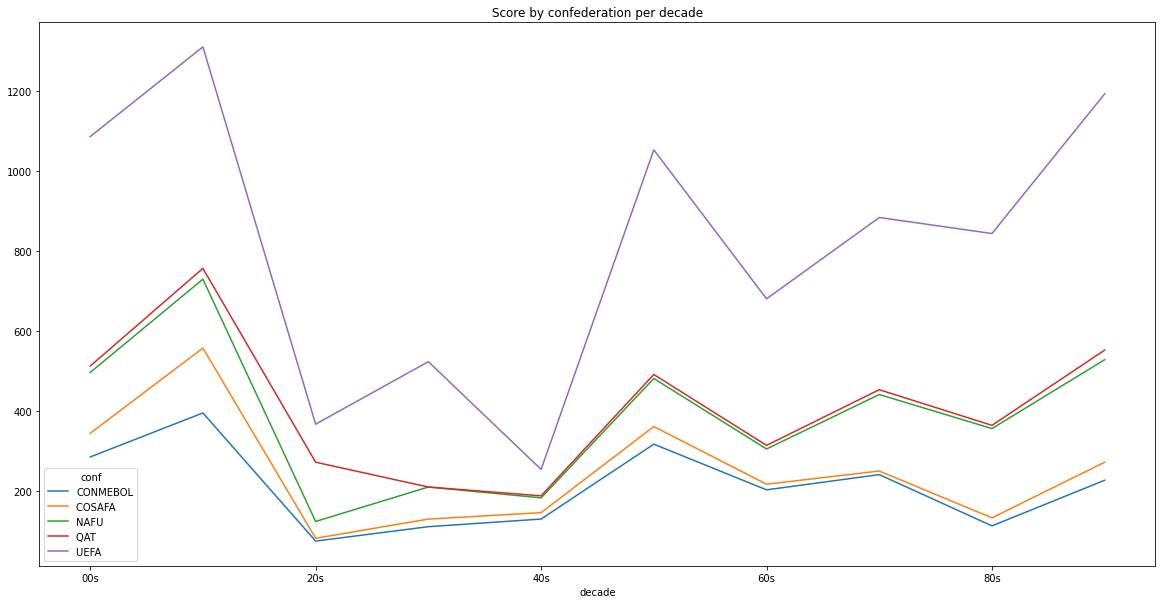

In [9]:
# Score by confederation per decade

world_cup['conf'].groupby(world_cup['decade']).value_counts().unstack().plot(kind='line', stacked=True, figsize=(20, 10), title= 'Score by confederation per decade')

<AxesSubplot: title={'center': 'Histogram of score per match'}, ylabel='Frequency'>

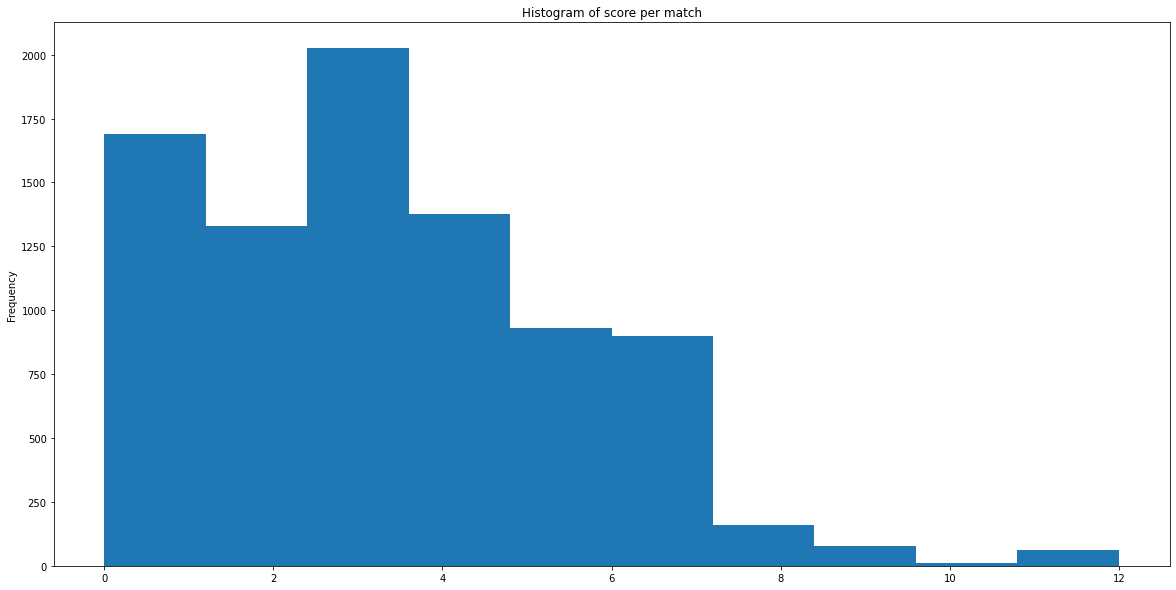

In [10]:
# Histogram of score per match

world_cup['total_goals'] = world_cup['home_score'] + world_cup['away_score']
world_cup['total_goals'].plot(kind='hist', figsize=(20, 10), title= 'Histogram of score per match')

<AxesSubplot: title={'center': 'Freq of goals of winning team per match'}, ylabel='Frequency'>

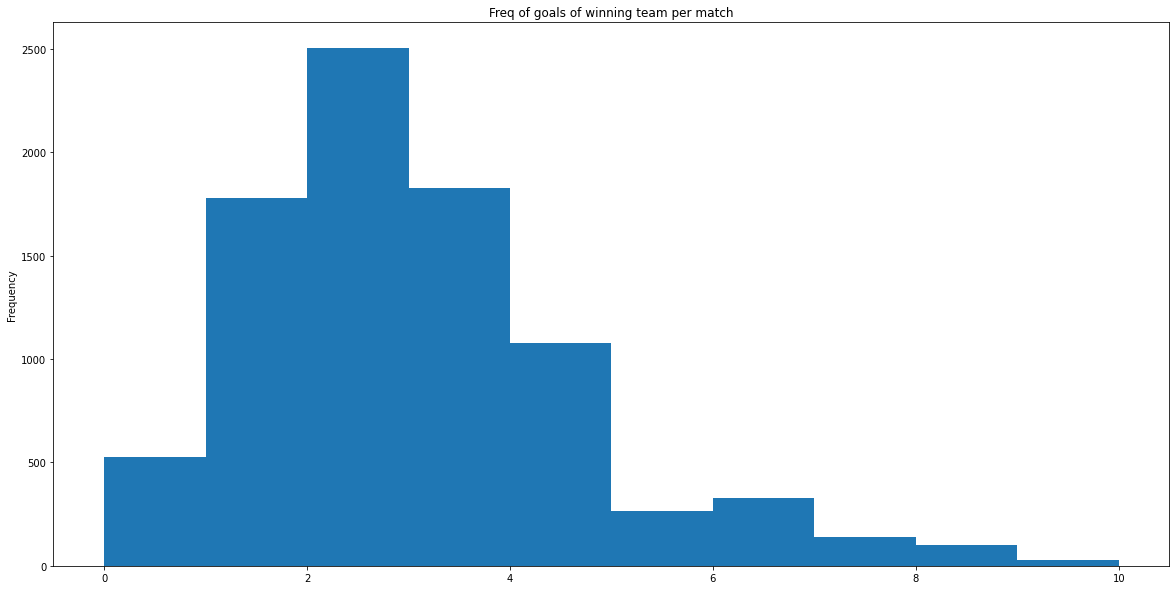

In [11]:
# Freq of goals of winning team per match
world_cup['winning_team_score'] = world_cup[['home_score', 'away_score']].max(axis=1)
world_cup['winning_team_score'].plot(kind='hist', figsize=(20, 10), title= 'Freq of goals of winning team per match')


<AxesSubplot: title={'center': 'Top 10 teams with most wins'}, xlabel='winner'>

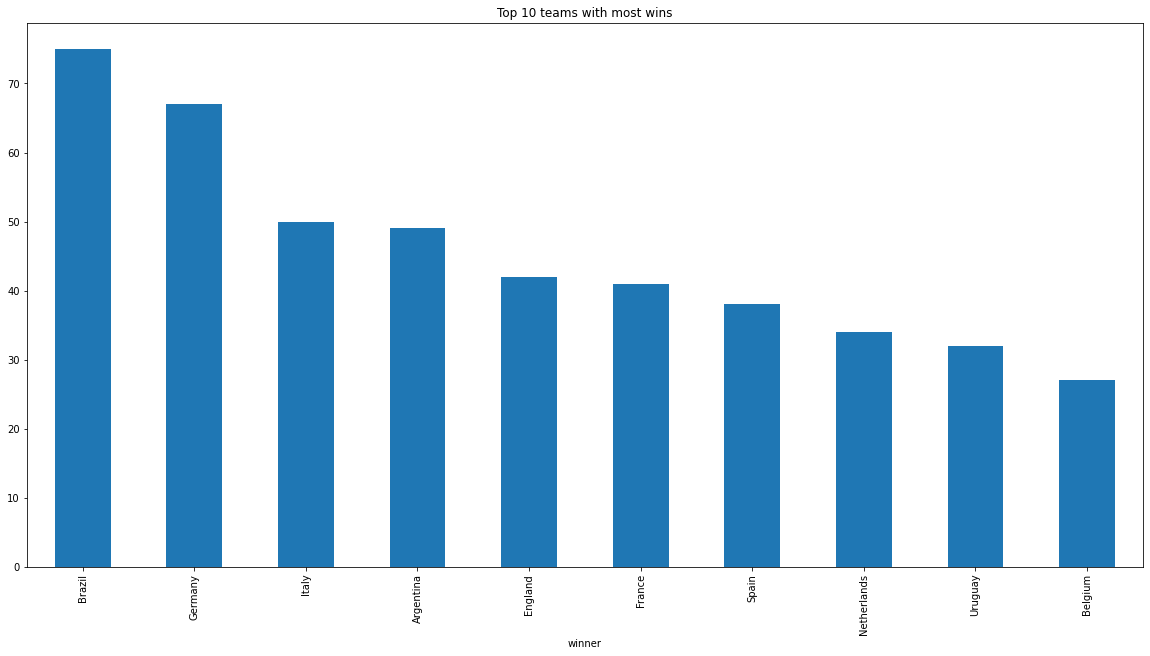

In [12]:
# Top 10 teams with most wins

df_matches = world_cup[['home_team', 'away_team', 'home_score', 'away_score', 'winner']].drop_duplicates()
wins = df_matches.groupby('winner').size().sort_values(ascending=False)
top_10_teams = wins.head(10)
top_10_teams.plot(kind='bar', figsize=(20, 10), title='Top 10 teams with most wins')

<AxesSubplot: title={'center': 'Best Scorers'}>

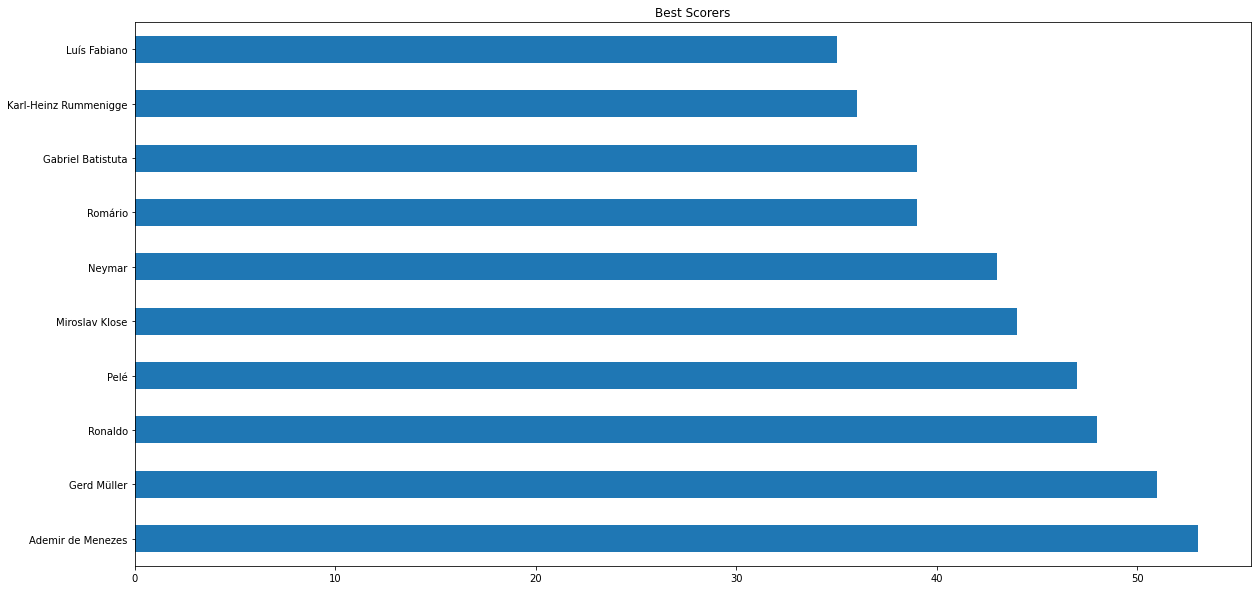

In [13]:
# best scorers
world_cup['scorer'].value_counts().head(10).plot(kind='barh', figsize=(20, 10), title= 'Best Scorers')

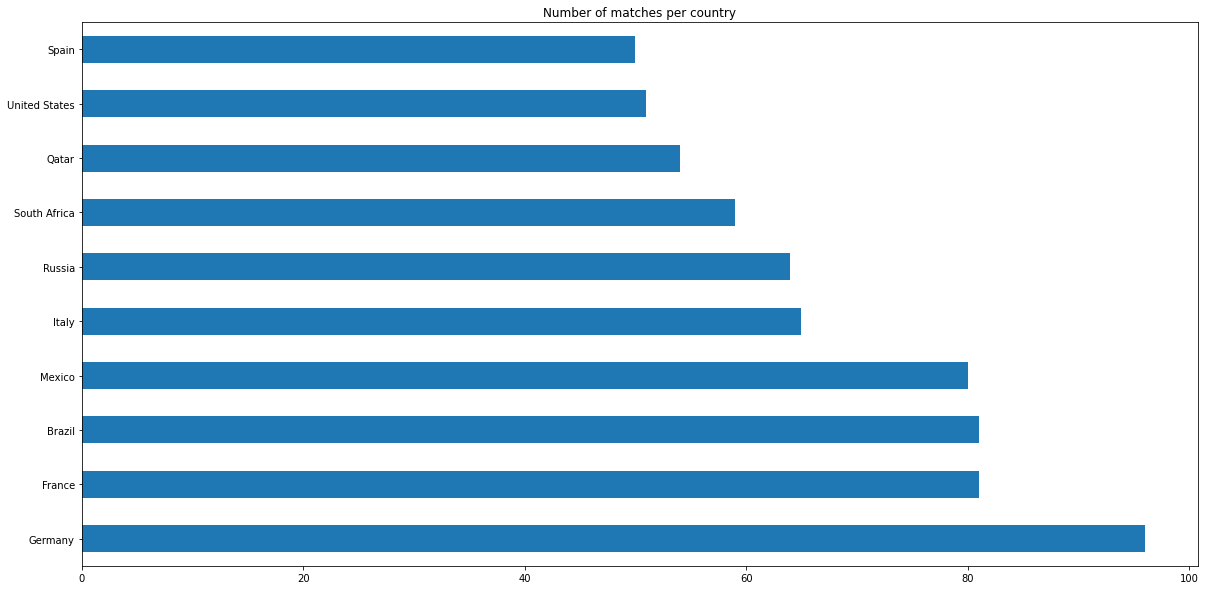

In [14]:
# Top 10 counties with most matches played

df_matches = world_cup[['home_team', 'away_team', 'home_score', 'away_score', 'winner', 'country']].drop_duplicates()
matches_per_country = df_matches['country'].value_counts().head(10).plot(kind='barh', figsize=(20, 10), title='Number of matches per country')


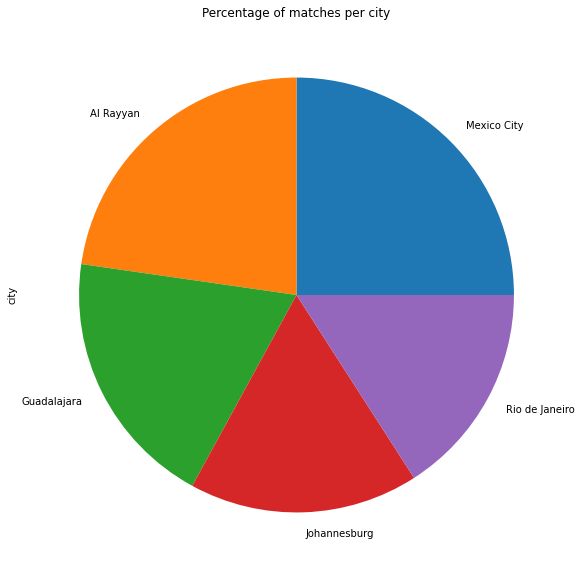

In [15]:
# Percentage of matches per city
df_matches = world_cup[['home_team', 'away_team', 'home_score', 'away_score', 'winner', 'city']].drop_duplicates()
matches_per_city = df_matches['city'].value_counts().head(5).plot(kind='pie', figsize=(20, 10), title='Percentage of matches per city')